In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
import pandas as pd
from tensorflow import keras
from utils.helper import (
    folder_to_sequence,
    MinMaxScaler_AE,
)

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

In [ ]:
# carregando os dados para a memória
DEFAULT_WS = 80
normal = folder_to_sequence("VIDRO-B3", DEFAULT_WS)
anomaly1 = folder_to_sequence("ANOMALIAS/B3+200g", DEFAULT_WS)
anomaly2 = folder_to_sequence("ANOMALIAS/vazoes-aleatorias", DEFAULT_WS)

In [3]:
scaler = MinMaxScaler_AE()
scaler.fit(normal)

In [4]:
autoencoder = keras.models.load_model("best_model.keras")

In [5]:
# 1) Analisar os erros no conjunto de treino

def get_error_dist(data : np.ndarray, color:str, cumulative=False):
    xnorm = scaler.transform(data)
    xpred = autoencoder.predict(xnorm)

    xnorm = np.squeeze(xnorm, axis=-1)
    errors = np.mean(np.abs(xnorm - xpred), axis=1)

    max_error = np.percentile(errors, 95)

    fig, ax = plt.subplots()
    ax.grid()
    sns.histplot(errors, kde=True, bins=50, color = color, stat = "percent", ax = ax, cumulative = cumulative)
    ax.set_ylabel(r"Porcentagem (%)")
    ax.set_xlabel("Erro médio absoluto")

    return ax, max_error, errors

In [ ]:
ax, max_error, _ = get_error_dist(normal, color="blue")
print(max_error)

In [7]:
def get_accuracy(errors: np.ndarray, threshold: float) -> float:
    anomalies = errors > threshold
    accuracy: float = np.mean(anomalies)
    return accuracy

In [ ]:
ax2, _, errors2 = get_error_dist(anomaly1, "red")
ax2.axvline(max_error, label="Limiar de decisão")
ax2.legend(title=f"Acurácia: {get_accuracy(errors2, max_error) * 100:.2f}%")

In [ ]:
ax3, _, errors3 = get_error_dist(anomaly2, "green")
ax3.axvline(max_error, label="Limiar de decisão")
ax3.legend(title=f"Acurácia: {get_accuracy(errors3, max_error) * 100:.2f}%")

In [ ]:
ax4, _, errors4 = get_error_dist(anomaly3, "orange")
ax4.axvline(max_error, label="Limiar de decisão")
ax4.legend(title=f"Acurácia: {get_accuracy(errors4, max_error) * 100:.2f}%")

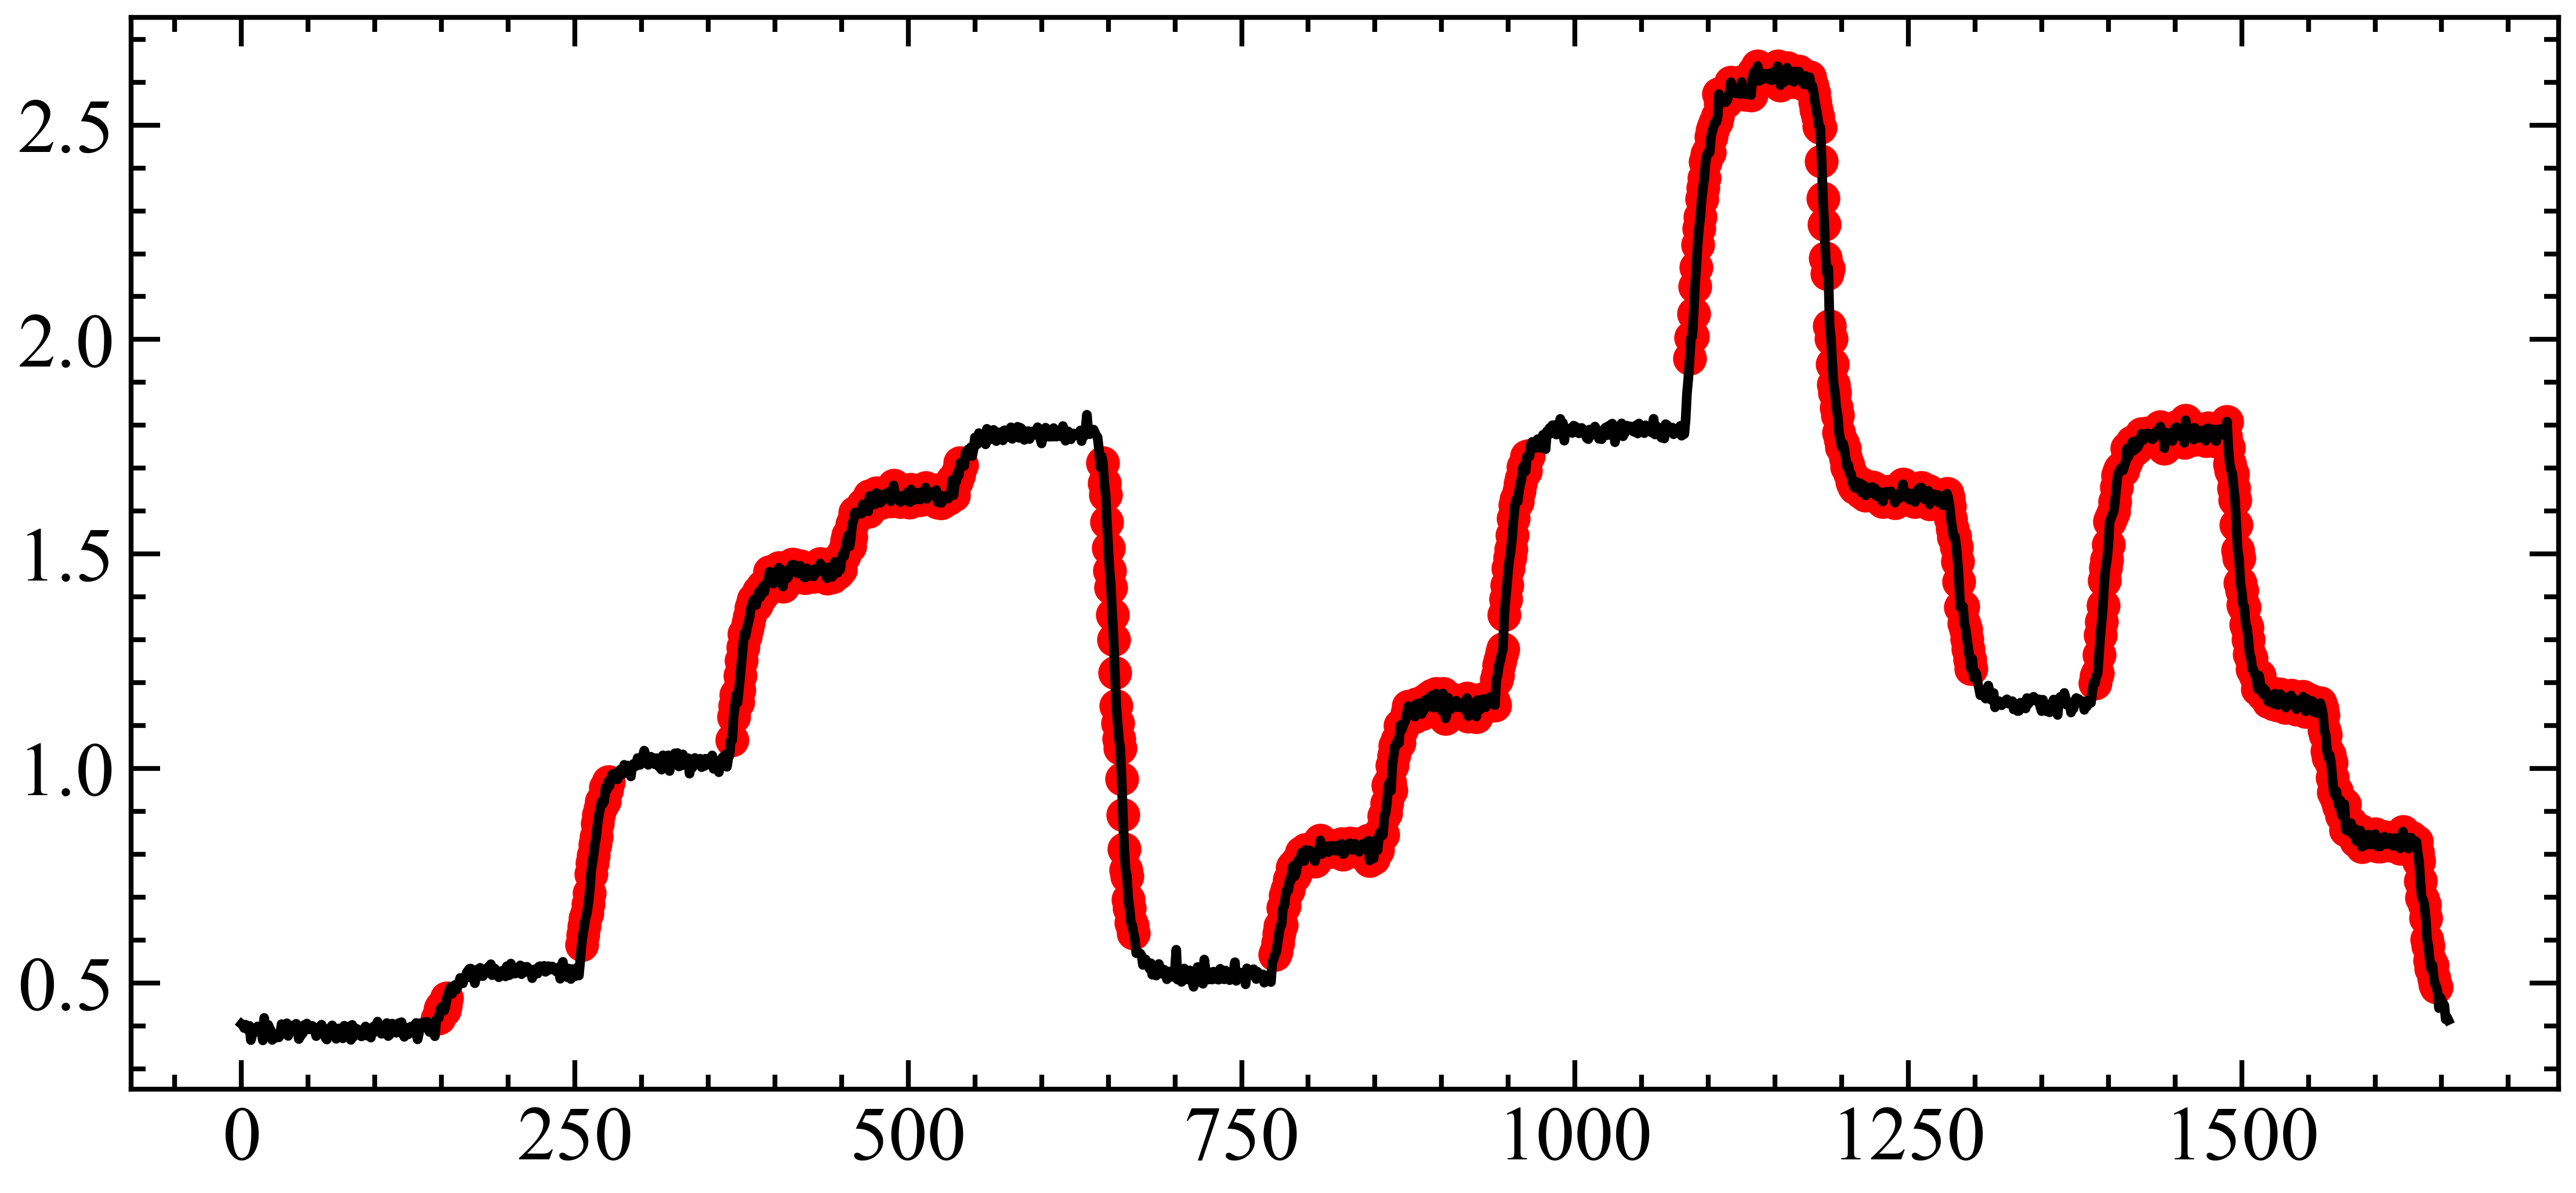

In [37]:
anomaly_points = errors3 > max_error
combined_anomaly_points = np.zeros_like(anomaly_points, dtype=bool)
for i in range(DEFAULT_WS - 1, len(anomaly_points)):
    if np.all(anomaly_points[i - DEFAULT_WS + 1 : i + 1]):
        combined_anomaly_points[i] = True


plt.plot(anomaly2[:, 0, 0])
plt.scatter(np.where(combined_anomaly_points)[0], anomaly2[combined_anomaly_points, 0, 0], c="r")